<a href="https://colab.research.google.com/github/rrfsantos/BNDES-premiodadosabertos/blob/main/LDA_WordCloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alocação Latente de Dirichlet (LDA) - Análise de tópicos e estudo de termos mais frequentes em:

1.   Contratos de Banco de Serviços -> https://dadosabertos.bndes.gov.br/group/desestatizacao

2.   Contratos de Operações de Financiamento não Automáticas ->  https://dadosabertos.bndes.gov.br/dataset/operacoes-financiamento

In [1]:
!python -m pip install pyLDAvis==2.1.2

     |████████████████████████████████| 1.6 MB 4.9 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=2f02073396f3bcc3fc4419c40c2bd4a14ac3e75898e3f46ba373d037265bb24f
  Stored in directory: /root/.cache/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
Successfully built pyLDAvis


In [2]:
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

# Visualização
import pyLDAvis
import pyLDAvis.sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline


# Outras Bibliotecas
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

np.random.seed(0)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


# Banco de Serviços

### Estatísticas da atuação do BNDES como Banco de Serviços. https://dadosabertos.bndes.gov.br/group/desestatizacao

#### Vetorização das palavras para entrada nos modelos de ML

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive/BNDES/'
os.chdir(workdir_path)

Mounted at /content/drive


In [4]:
# Leitura do dataset
df_bs = pd.read_csv('contratos_bs.csv', sep=';', encoding='UTF-8')
corpus_bs = df_bs.texto

In [5]:
# Vetorização de palavras - TF-IDF
vectorizer_bs = TfidfVectorizer(analyzer='word',       
                             lowercase=True,                   # converter todas as palavras em minúsculas
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3 - para ser qualificado como token
                             ngram_range = (2,3),              # uni, bi e trigrams
                             max_features=300
                            )

data_vectorized_bs = vectorizer_bs.fit_transform(corpus_bs)

#### Utilização de GridSearch para encontrar melhor modelo LDA

In [6]:
# Parâmetros de busca
search_params = {'n_components': [3, 5, 10, 15], 'learning_decay': [.3, .5, .7, .9]}

# Inicializa o modelo
lda = LatentDirichletAllocation()

# Inicializa Grid Search Class
model_bs = GridSearchCV(lda, param_grid=search_params)

# Faz a Grid Search
model_bs.fit(data_vectorized_bs)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

#### Escolher o "melhor" modelo

In [7]:
# Melhor modelo
best_lda_model_bs = model_bs.best_estimator_

# Hiperparâmetros do modelo
print("Melhores parâmetros: ", model_bs.best_params_)

# probabilidade logarítmica
print("Melhor score de probabilidade logarítmica: ", model_bs.best_score_)

# Perplexidade
print("Perplexidade do modelo: ", best_lda_model_bs.perplexity(data_vectorized_bs))

# Utilizar o melhor modelo
lda_output_bs = best_lda_model_bs.transform(data_vectorized_bs)

Melhores parâmetros:  {'learning_decay': 0.7, 'n_components': 3}
Melhor score de probabilidade logarítmica:  -507.81263265560375
Perplexidade do modelo:  796.1940000808252


#### Visualizar o modelo LDA com o pyLDAvis

In [8]:
# Visualização via pyLDAvis
pyLDAvis.enable_notebook() 
panel = pyLDAvis.sklearn.prepare(best_lda_model_bs, data_vectorized_bs, vectorizer_bs, mds='tsne')
pyLDAvis.save_html(panel, 'lda_bs.html') 
pyLDAvis.display(panel)

#### WordCloud com as 30 expressões (ngram) mais frequentes por tópico

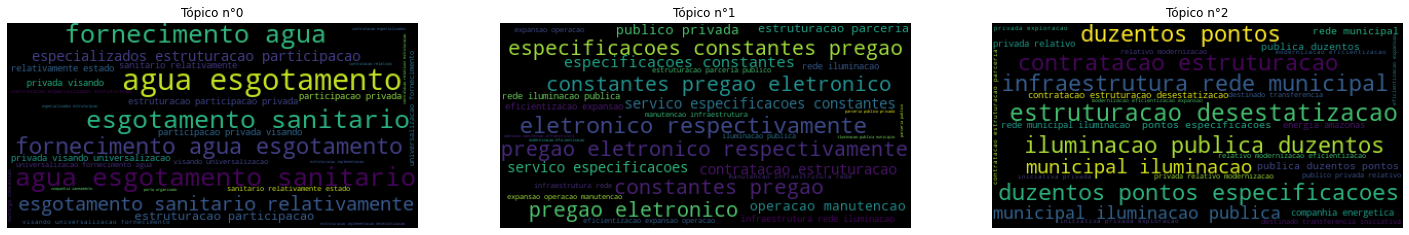

In [9]:
# Wordcloud
tf_feature_names_bs = vectorizer_bs.get_feature_names()

fig = plt.figure(figsize=(25,20))
for i in range(len(best_lda_model_bs.components_)):
    topic = best_lda_model_bs.components_[i]
    tupleList = [(tf_feature_names_bs[i], int(topic[i]/topic.sum()*10000)) for i in range(len(topic))]
    ax = fig.add_subplot(3,3,i+1)
    wordcloud = WordCloud(max_words=30).generate_from_frequencies(dict(tupleList))
    ax.imshow(wordcloud)
    ax.set_title('Tópico n°{}' .format(i))
    ax.axis('off');

# Operações de Financiamento não Automáticas

##### Dados detalhados das condições das operações de financiamento contratadas, incluindo condições de financiamento, porte do cliente e produto contratado. https://dadosabertos.bndes.gov.br/dataset/operacoes-financiamento

#### Vetorização das palavras para entrada nos modelos de ML

In [10]:
# Leitura do dataset
df_ofna = pd.read_csv('contratos_ofna.csv', sep=';', encoding='UTF-8')
corpus_ofna = df_ofna.descricao_do_projeto

In [11]:
# Vetorização de palavras - TF-IDF
vectorizer_ofna = TfidfVectorizer(analyzer='word',       
                             lowercase=True,                   # converter todas as palavras em minúsculas
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3 - para ser qualificado como token
                             ngram_range = (1,3),              # uni, bi e trigrams
                             max_features=300
                            )
data_vectorized_ofna = vectorizer_ofna.fit_transform(corpus_ofna)

#### Utilização de GridSearch para encontrar melhor modelo LDA

In [12]:
# Parâmetros de busca
search_params = {'n_components': [3, 5, 10, 15], 'learning_decay': [.3, .5, .7, .9]}

# Inicializa o modelo
lda = LatentDirichletAllocation()

# Inicializa Grid Search Class
model_ofna = GridSearchCV(lda, param_grid=search_params)

# Faz a Grid Search
model_ofna.fit(data_vectorized_ofna)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

#### Escolher o "melhor" modelo

In [13]:
# Melhor modelo
best_lda_model_ofna = model_ofna.best_estimator_

# Hiperparâmetros do modelo
print("Melhores parâmetros: ", model_ofna.best_params_)

# probabilidade logarítmica
print("Melhor score de probabilidade logarítmica: ", model_ofna.best_score_)

# Perplexidade
print("Perplexidade do modelo: ", best_lda_model_ofna.perplexity(data_vectorized_ofna))

# Utilizar o melhor modelo
lda_output_ofna = best_lda_model_ofna.transform(data_vectorized_ofna)

Melhores parâmetros:  {'learning_decay': 0.3, 'n_components': 3}
Melhor score de probabilidade logarítmica:  -63306.47154315256
Perplexidade do modelo:  252.6106573050165


#### Visualizar o modelo LDA com o pyLDAvis

In [14]:
# Visualização via pyLDAvis
pyLDAvis.enable_notebook() 
panel = pyLDAvis.sklearn.prepare(best_lda_model_ofna, data_vectorized_ofna, vectorizer_ofna, mds='tsne')
pyLDAvis.save_html(panel, 'lda_ofna.html') 
pyLDAvis.display(panel)

#### WordCloud com as 30 expressões (ngram) mais frequentes por tópico

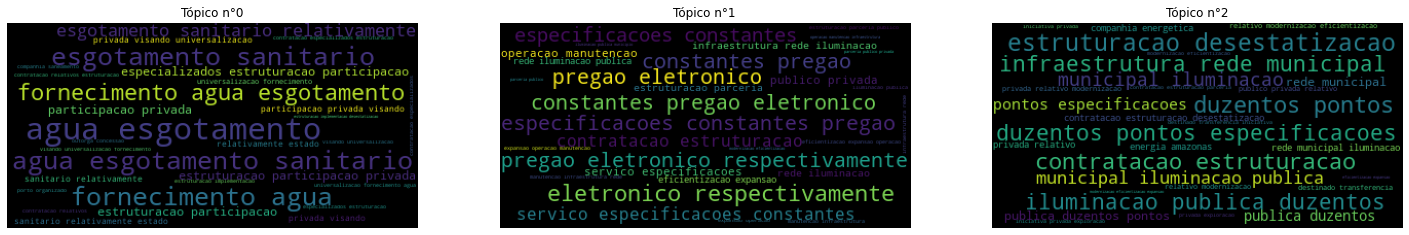

In [15]:
# Wordcloud
tf_feature_names_ofna = vectorizer_ofna.get_feature_names()

fig = plt.figure(figsize=(25,20))
for i in range(len(best_lda_model_bs.components_)):
    topic = best_lda_model_bs.components_[i]
    tupleList = [(tf_feature_names_bs[i], int(topic[i]/topic.sum()*10000)) for i in range(len(topic))]
    tupleList.sort(key=itemgetter(1))
    ax = fig.add_subplot(3,3,i+1)
    wordcloud = WordCloud(max_words=30).generate_from_frequencies(dict(tupleList))
    ax.imshow(wordcloud)
    ax.set_title('Tópico n°{}' .format(i))
    ax.axis('off');